In [50]:
import torch
from d2l import torch as d2l
import torchvision
from torch import nn

In [51]:
# predictor
def cls_predictor(n_inputs, n_anchors, n_classes):
    return nn.Conv2d(n_inputs, n_anchors * (n_classes + 1), kernel_size=3, padding=1)

def bbox_predictor(n_inputs, n_anchors):
    return nn.Conv2d(n_inputs, n_anchors * 4, kernel_size=3, padding=1)

In [52]:
# flatten
def flatten_pred(pred):
    # NCHW to NHWC
    return torch.flatten(pred.permute(0, 2, 3, 1), start_dim=1)

def concat_preds(preds):
    return torch.cat([flatten_pred(pred) for pred in preds], dim=1)

In [53]:
def down_sample_blk(n_inputs, n_outputs):
    blk = []
    for _ in range(2):
        blk.append(nn.Conv2d(n_inputs, n_outputs, kernel_size=3, padding=1))
        blk.append(nn.BatchNorm2d(n_outputs))
        blk.append(nn.ReLU())
        n_inputs = n_outputs
    blk.append(nn.MaxPool2d(2))
    return nn.Sequential(*blk)
def base_net():
    blk = []
    n_channels = [3, 16, 32, 64]
    for i in range(len(n_channels) - 1):
        blk.append(down_sample_blk(n_channels[i], n_channels[i + 1]))
    return nn.Sequential(*blk)

In [54]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 1:
        blk = down_sample_blk(64, 128)
    elif i == 4:
        blk = nn.AdaptiveMaxPool2d((1,1))
    else:
        blk = down_sample_blk(128, 128)
    return blk

In [55]:
def blk_forward(x, blk, size, ratio, cls_predictor, bbox_predictor):
    y_hat = blk(x)
    anchors = d2l.multibox_prior(y_hat, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(y_hat)
    bbox_preds = bbox_predictor(y_hat)
    return (y_hat, anchors, cls_preds, bbox_preds)

In [56]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79],
         [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
n_anchors = len(sizes[0]) + len(ratios[0]) - 1

In [57]:
class TinySSD(nn.Module):

    def __init__(self, n_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.n_classes = n_classes
        channels = [64, 128, 128, 128, 128]
        for i in range(5):
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(channels[i], n_anchors,
                    n_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(channels[i], n_anchors))

    def forward(self, x):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            x, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                x, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        anchors = torch.cat(anchors, dim=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(
            (cls_preds.shape[0], -1, self.n_classes + 1))
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

In [58]:
net = TinySSD(1)
x = torch.zeros((32, 3, 256, 256))
anchors, cls_prds, bbox_preds = net(x)

In [59]:
anchors.shape, cls_prds.shape, bbox_preds.shape

(torch.Size([1, 5444, 4]), torch.Size([32, 5444, 2]), torch.Size([32, 21776]))

In [60]:
batch_size = 32
train_iter, _ = d2l.load_data_bananas(batch_size)

read 1000 training examples
read 100 validation examples


In [61]:
cls_loss = nn.CrossEntropyLoss(reduction='none')
bbox_loss = nn.L1Loss(reduction='none')

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    batch_size, num_classes = cls_preds.shape[0], cls_preds.shape[2]
    cls = cls_loss(cls_preds.reshape(-1, num_classes),
                   cls_labels.reshape(-1)).reshape(batch_size, -1).mean(dim=1)
    bbox = bbox_loss(bbox_preds * bbox_masks,
                     bbox_labels * bbox_masks).mean(dim=1)
    return cls + bbox

# def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
#     batch_size, n_clsses = cls_preds.shape[0], cls_preds.shape[2]
#     _cls_loss = cls_loss(cls_preds.reshape((-1, n_clsses)), cls_labels.reshape((-1)).reshape(batch_size, -1)).mean(dim=1)
#     _bbox_loss = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks).mean(dim=1)
#     return _cls_loss + _bbox_loss

def cls_eval(cls_preds, cls_labels):
    # Because the class prediction results are on the final dimension,
    # `argmax` needs to specify this dimension
    return float((cls_preds.argmax(dim=-1).type(
        cls_labels.dtype) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((torch.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

class err 3.29e-03, bbox mae 3.21e-03
13452.6 examples/sec on cuda:0


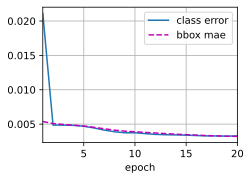

In [62]:
n_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch',
                        xlim=[1, n_epochs],
                        legend=['class error', 'bbox mae'])

device, net = d2l.try_gpu(), TinySSD(1)
trainer = torch.optim.SGD(net.parameters(), lr=2e-1, weight_decay=5e-4)

net = net.to(device)
for epoch in range(n_epochs):
    metric = d2l.Accumulator(4)
    net.train()
    for x, y in train_iter:
        timer.start()
        trainer.zero_grad()
        x, y = x.to(device), y.to(device)
        anchors, cls_preds, bbox_preds = net(x)
        bbox_labels, bbox_masks, cls_labels = d2l.multibox_target(anchors, y)
        loss = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels,
                         bbox_masks)
        loss.mean().backward()
        trainer.step()
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.numel(),
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.numel())
    cls_err, bbox_mae = 1 - metric[0] / metric[1], metric[2] / metric[3]
    animator.add(epoch + 1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{len(train_iter.dataset) / timer.stop():.1f} examples/sec on '
      f'{str(device)}')